<a href="https://colab.research.google.com/github/Aditya8215/RedBus-Hackathon_project/blob/main/RedBus_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Your goal:

Predict the demand (total number of seats booked) for each journey at the route level, 15 days before the actual date of journey (doj).
Example: For a route from Source City "A" to Destination City "B" with a date of journey (doj) on 30-Jan-2025, you need to predict the final seat count for this route on 16-Jan-2025, which is exactly 15 days prior to the journey date.

Evaluation Metric:


The evaluation metric for this hackathon would be RMSE (Root Mean Squared Error).

#Data dictionary
The following table provides a comprehensive data dictionary, outlining the structure and description of each variable used in the given dataset.


#1. train.csv

Variable

Description

doj (Date of Journey)

The date on which the bus journey is scheduled to take place.

srcid (Source City ID)

Unique identifier for the source city of the journey.

destid (Destination City ID)

Unique identifier for the destination city of the journey.

final_seatcount

Total number of seats booked at the end of the journey date (Target Variable).

#2. test.csv

Variable

Description

route_key

Unique identifier for each row in the test set.

doj (Date of Journey)

The date on which the bus journey is scheduled to take place.

srcid (Source City ID)

Unique identifier for the source city of the journey.

destid (Destination City ID)

Unique identifier for the destination city of the journey.


#3. transactions.csv

Variable

Description

doj (Date of Journey)

The date on which the bus journey is scheduled to take place.

doi (Date of Issue)

The date when the ticket was booked.

dbd (Days Before Departure)

The number of days remaining until the journey date from the date of issue, for a given srcid, destid, doi and doj combination.

srcid (Source City ID)

Unique identifier for the source city of the journey.

destid (Destination City ID)

Unique identifier for the destination city of the journey.

srcid_region

The region (state) where the source city is located.

destid_region

The region (state) where the destination city is located.

srcid_tier

The tier classification of the source city (e.g., Tier 1, Tier 2).

destid_tier

The tier classification of the destination city (e.g., Tier 1, Tier 2).

cumsum_seatcount

This represents the cumulative number of seats sold till date.

cumsum_searchcount

This will represent the cumulative number of searches till date.

#4. submission_file.csv

Variable

Description

route_key

Unique identifier for each row in the test set.

final_seatcount

Total number of seats booked at the end of the journey date (Target Variable).



In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
train=pd.read_csv("/content/train.csv")
df=pd.read_csv("/content/transactions.csv")
test=pd.read_csv("/content/test_8gqdJqH.csv")


In [141]:
train.head(),train.shape

(          doj  srcid  destid  final_seatcount
 0  2023-03-01     45      46           2838.0
 1  2023-03-01     46      45           2298.0
 2  2023-03-01     45      47           2720.0
 3  2023-03-01     47      45           2580.0
 4  2023-03-01     46       9           4185.0,
 (67200, 4))

In [142]:
test.head(),test.shape

(          route_key         doj  srcid  destid
 0  2025-02-11_46_45  2025-02-11     46      45
 1  2025-01-20_17_23  2025-01-20     17      23
 2  2025-01-08_02_14  2025-01-08      2      14
 3  2025-01-08_08_47  2025-01-08      8      47
 4  2025-01-08_09_46  2025-01-08      9      46,
 (5900, 4))

In [144]:
df.head(),df.shape

(          doj         doi  srcid  destid    srcid_region   destid_region  \
 0  2023-03-01  2023-01-30     45      46       Karnataka      Tamil Nadu   
 1  2023-03-01  2023-01-30     46      45      Tamil Nadu       Karnataka   
 2  2023-03-01  2023-01-30     45      47       Karnataka  Andhra Pradesh   
 3  2023-03-01  2023-01-30     47      45  Andhra Pradesh       Karnataka   
 4  2023-03-01  2023-01-30     46       9      Tamil Nadu      Tamil Nadu   
 
   srcid_tier destid_tier  cumsum_seatcount  cumsum_searchcount   dbd  
 0     Tier 1      Tier 1               8.0                76.0  30.0  
 1     Tier 1      Tier 1               8.0                70.0  30.0  
 2     Tier 1      Tier 1               4.0               142.0  30.0  
 3     Tier 1      Tier 1               0.0                68.0  30.0  
 4     Tier 1       Tier2               9.0               162.0  30.0  ,
 (2120740, 11))

In [145]:
df['route_key'] = df['doj'].astype(str) + '_' + df['srcid'].astype(str) + '_' + df['destid'].astype(str)
train['route_key'] = train['doj'].astype(str) + '_' + train['srcid'].astype(str) + '_' + train['destid'].astype(str)
df.drop(['doj','srcid','destid'],axis=1)
train.drop(['doj','srcid','destid'],axis=1)

,final_seatcount,route_key
0,2838.0,2023-03-01_45_46
1,2298.0,2023-03-01_46_45
2,2720.0,2023-03-01_45_47
3,2580.0,2023-03-01_47_45
4,4185.0,2023-03-01_46_9
...,...,...
67195,800.0,2024-12-31_2_24
67196,1360.0,2024-12-31_44_45
67197,560.0,2024-12-31_47_10
67198,535.0,2024-12-31_38_36


In [ ]:
df['route_key'].unique().shape

In [108]:
# from ydata_profiling import ProfileReport
# prof=ProfileReport(df,explorative=True)
# prof.to_file(output_file="EDA_Redbus1.html")

In [134]:
test.shape,train.shape,df.shape

((5900, 4), (67200, 4), (1342249, 11))

In [110]:
df.isnull().sum()

,0
doj,0
doi,0
srcid,1
destid,1
srcid_region,1
destid_region,1
srcid_tier,1
destid_tier,1
cumsum_seatcount,1
cumsum_searchcount,1


In [111]:
df.duplicated().sum()

np.int64(0)

# Converting Tier into Numerical value

In [112]:
df['srcid_tier'].value_counts()

,count
srcid_tier,
Tier 1,791930
Tier2,416097
Tier 3,80533
Tier 4,53688


In [113]:
for i in range(1,5):
  if(i==2):
    df['srcid_tier']=df['srcid_tier'].replace(f"Tier{i}",i)
    df['destid_tier']=df['destid_tier'].replace(f"Tier{i}",i)
  else:
    df['srcid_tier']=df['srcid_tier'].replace(f"Tier {i}",i)
  df['destid_tier']=df['destid_tier'].replace(f"Tier {i}",i)

# Data Visualization

In [114]:
values1=df['srcid_region'].value_counts()
values2=df['destid_region'].value_counts()

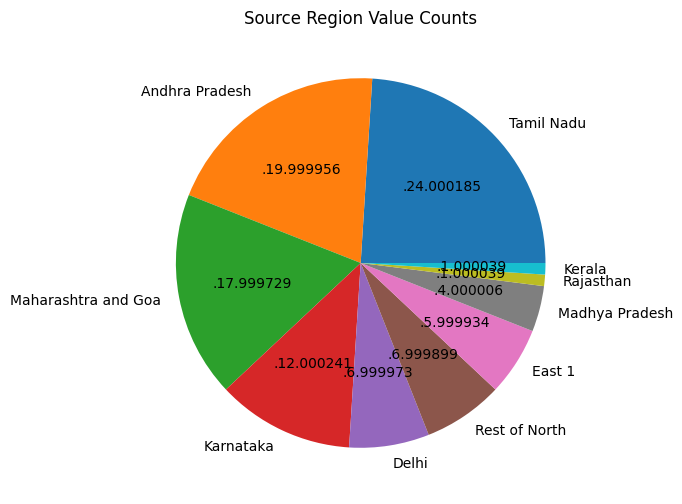

In [115]:
labels=values1.index
plt.figure(figsize=(8,6))
plt.title("Source Region Value Counts")
plt.pie(values1,labels=labels,autopct=".%2f")
plt.show()

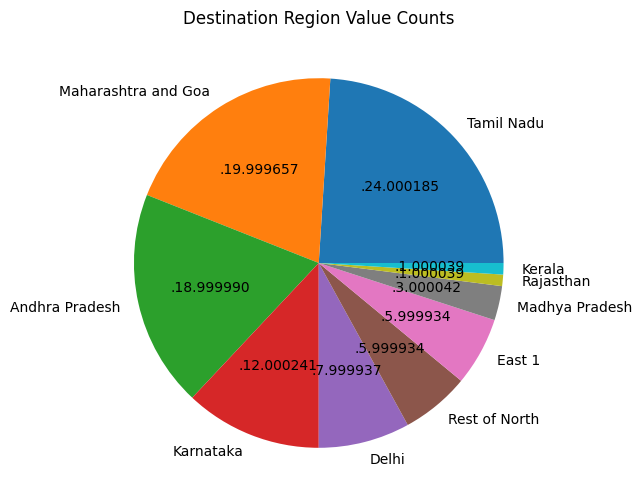

In [116]:
labels2=values2.index
plt.figure(figsize=(8,6))
plt.title("Destination Region Value Counts")
plt.pie(values2,labels=labels2,autopct=".%2f")
plt.show()

#Findding correlation between each city

In [117]:
df['srcid_region'].unique()

array(['Karnataka', 'Tamil Nadu', 'Andhra Pradesh', 'Maharashtra and Goa',
       'Rest of North', 'Madhya Pradesh', 'Delhi', 'Rajasthan', 'East 1',
       'Kerala', nan], dtype=object)

<Axes: xlabel='destid_region', ylabel='srcid_region'>

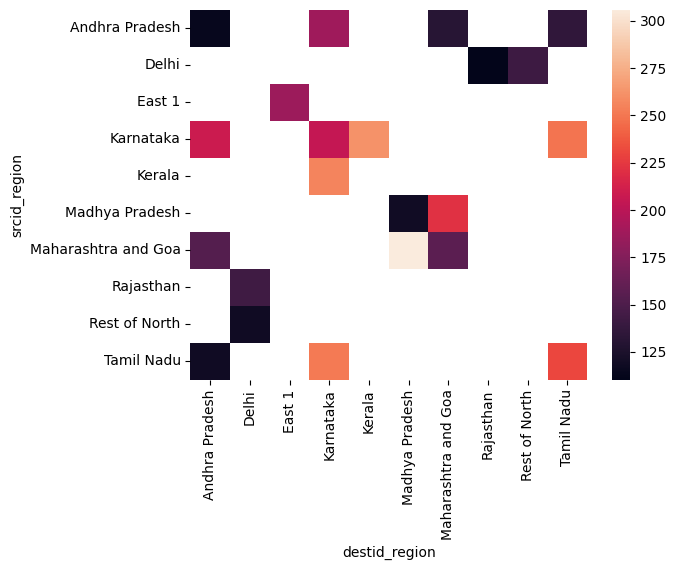

In [118]:
sns.heatmap(df.pivot_table(values='cumsum_seatcount',columns='destid_region',index='srcid_region'))

In [119]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)

In [120]:
# # Converting Regions into Numerical Values
src_regions = df['srcid_region'].unique()
dest_regions = df['destid_region'].unique()

# Create mappings
src_region_map = {region: i for i, region in enumerate(src_regions)}
dest_region_map = {region: i for i, region in enumerate(dest_regions)}

# Apply mappings
df['srcid_region_encoded'] = df['srcid_region'].map(src_region_map)
df['destid_region_encoded'] = df['destid_region'].map(dest_region_map)

# Display the first few rows to check the result
print(df[['srcid_region', 'srcid_region_encoded', 'destid_region', 'destid_region_encoded']].head())

     srcid_region  srcid_region_encoded   destid_region  destid_region_encoded
0       Karnataka                     0      Tamil Nadu                      0
1      Tamil Nadu                     1       Karnataka                      1
2       Karnataka                     0  Andhra Pradesh                      2
3  Andhra Pradesh                     2       Karnataka                      1
4      Tamil Nadu                     1      Tamil Nadu                      0


In [121]:
df = df.drop(['srcid_region', 'destid_region'], axis=1)

In [122]:
df.head()

,doj,doi,srcid,destid,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,srcid_region_encoded,destid_region_encoded
0,2023-03-01,2023-01-30,45.0,46.0,1,1,8.0,76.0,30.0,0,0
1,2023-03-01,2023-01-30,46.0,45.0,1,1,8.0,70.0,30.0,1,1
2,2023-03-01,2023-01-30,45.0,47.0,1,1,4.0,142.0,30.0,0,2
3,2023-03-01,2023-01-30,47.0,45.0,1,1,0.0,68.0,30.0,2,1
4,2023-03-01,2023-01-30,46.0,9.0,1,2,9.0,162.0,30.0,1,0


In [123]:
# df['doj'] = pd.to_datetime(df['doj'], errors='coerce')
# df['doi'] = pd.to_datetime(df['doi'], errors='coerce')

# # Extract features from date of journey
# df['doj_year'] = df['doj'].dt.year
# df['doj_month'] = df['doj'].dt.month
# df['doj_day'] = df['doj'].dt.day
# df['doj_weekday'] = df['doj'].dt.weekday

# # Extract features from date of issue
# df['doi_year'] = df['doi'].dt.year
# df['doi_month'] = df['doi'].dt.month
# df['doi_day'] = df['doi'].dt.day
# df['doi_weekday'] = df['doi'].dt.weekday


# # Drop original date columns
# df = df.drop(['doj', 'doi'], axis=1)

# df.head()

In [124]:
df.sample(5)

,doj,doi,srcid,destid,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,srcid_region_encoded,destid_region_encoded
990878,2024-01-14,2024-01-03,47.0,6.0,1,3,100.0,4720.0,11.0,2,2
1241331,2024-04-04,2024-03-18,7.0,36.0,2,2,0.0,240.0,17.0,4,4
886423,2023-12-11,2023-12-10,40.0,2.0,1,1,1224.0,30308.0,1.0,3,3
122935,2023-04-09,2023-03-30,45.0,48.0,1,2,156.0,1324.0,10.0,0,0
688427,2023-10-09,2023-09-11,47.0,43.0,1,1,0.0,44.0,28.0,2,2


In [127]:
train_merged = pd.merge(train, df, on=['doj', 'srcid', 'destid'])
train_merged = train_merged.drop('doi', axis=1)


In [128]:
train_merged.head()

,doj,srcid,destid,final_seatcount,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,srcid_region_encoded,destid_region_encoded
0,2023-03-01,45,46,2838.0,1,1,8.0,76.0,30.0,0,0
1,2023-03-01,45,46,2838.0,1,1,8.0,94.0,29.0,0,0
2,2023-03-01,45,46,2838.0,1,1,8.0,108.0,28.0,0,0
3,2023-03-01,45,46,2838.0,1,1,8.0,126.0,27.0,0,0
4,2023-03-01,45,46,2838.0,1,1,8.0,146.0,26.0,0,0


In [131]:
X=train_merged.drop(["final_seatcount","doj"],axis=1)
y=train_merged["final_seatcount"]

In [132]:


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pca = PCA(n_components=)

In [133]:
# prompt: merge train, transaction and test data into a single dataframe on doj,srcid,destid

test_merged = pd.merge(test, df, train,on=['doj', 'srcid', 'destid'])
test_merged.head()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().